In [1]:
import os, sys
import numpy as np 
import sympy as sp 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib import cm
import math
import scipy as sci
from itertools import product 
from scipy.integrate import dblquad

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if os.path.isdir(os.path.join(PROJECT_ROOT, "src")):
    sys.path.insert(0, PROJECT_ROOT)
else:
    # fallback: try current directory
    sys.path.insert(0, os.getcwd())


from src.basis.basis import BasisHandler
from src.operators import differentiate
from primitives import Primitives_MinimalSupport
from src.matrix_generation import assemble_matrix_integral_1d
from time import time

In [147]:
primitives = Primitives_MinimalSupport()
bh = BasisHandler(primitives=primitives, dimension=2)
bh.build_basis(J_0=4,J_Max=4,comp_call=True)


In [124]:
#Utility functions

def filter_type(elems, filter_type):
    elems_filt=[elem for elem in elems if elem["type"]==filter_type]
    return elems_filt

def _symmetric_toeplitz(first_row):
    first_row = np.asarray(first_row)
    return np.array([np.roll(first_row, -i) for i in range(len(first_row))])


def _wrap_matrix(v, M):
    v = np.asarray(v)
    M = np.asarray(M)
    n = M.shape[0]

    out = np.empty((n+2, n+2), dtype=M.dtype)
    out[1:-1, 1:-1] = M
    out[0, :] = v
    out[:, 0] = v
    out[-1, :] = v[::-1]
    out[:, -1] = v[::-1]

    return out

def boundary_toeplitz(rows:list[list]):
    """TODO write desc here"""
    M= _symmetric_toeplitz(rows[0])
    # print(rows[0])
    # print(M.shape)
    if len(rows) == 1:
        return M
    for row in rows[1:]:
        M = _wrap_matrix(row, M)
    return M


def _extend_zero_right(arr,n):
    if len (arr) <n:
        arr=arr+[0]*(n-len(arr))
    return arr


((0, 1), (0, 1))


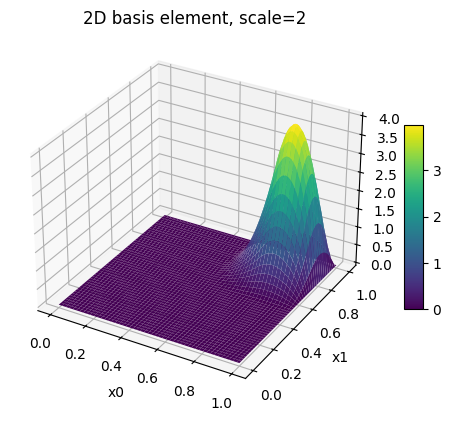

In [65]:
elems = bh.flatten()
center_scaling=filter_type(elems,filter_type=((0,0),(0,0)))
# elem=center_scaling[3]
elem=elems[15]
print(elem["type"])

x_range = np.linspace(0, 1, 200)
x0, x1 = sp.symbols("x0 x1")
f = sp.lambdify((x0, x1), elem["function_sym"](x0, x1), "numpy")
X, Y = np.meshgrid(x_range, x_range)
Z = f(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0, antialiased=True)
ax.set_title(f"2D basis element, scale={elem['scale']}")
ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("f(x0, x1)")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()

In [139]:
#FFT laplacian and other kernels: 

from numpy.polynomial.legendre import leggauss

def fractional_laplacian_point(u, x0, y0, s, 
                               x_min=-2.0, x_max=3.0,
                               y_min=-2.0, y_max=3.0,
                               q=40, C=1.0):
    """
    Approximate (-Δ)^s u(x0,y0) via the integral definition:

        (-Δ)^s u(x0) = C * ∫ (u(x0) - u(y)) / |x0 - y|^{2+2s} dy,

    using tensor Gauss–Legendre quadrature on [x_min,x_max]×[y_min,y_max],
    ignoring a tiny ball around y=(x0,y0) (principal value).

    u : callable u(x, y)
    s : fractional order (0 < s < 1 typical)
    q : # of Gauss points per dimension (40 is decent for a one-time benchmark)
    C : overall constant; if you care about the exact C_{2,s}, plug it in here.
    """
    # 1D Gauss–Legendre
    gx, wx = leggauss(q)
    gy, wy = leggauss(q)

    def map_interval(g, w, a, b):
        xm = 0.5 * (b - a) * g + 0.5 * (b + a)
        wm = 0.5 * (b - a) * w
        return xm, wm

    x_pts, x_w = map_interval(gx, wx, x_min, x_max)
    y_pts, y_w = map_interval(gy, wy, y_min, y_max)

    X, Y = np.meshgrid(x_pts, y_pts, indexing="ij")
    Wx, Wy = np.meshgrid(x_w, y_w, indexing="ij")
    W = Wx * Wy        # 2D weights

    ux0 = u(x0, y0)
    uy  = u(X, Y)

    dx = X - x0
    dy = Y - y0
    r2 = dx*dx + dy*dy

    # Principal value: ignore a tiny ball around r=0
    eps2 = 1e-10
    mask = r2 > eps2

    kernel = np.zeros_like(r2)
    kernel[mask] = 1.0 / (r2[mask] ** ((2.0 + 2.0*s)/2.0))

    integrand = (ux0 - uy) * kernel

    return C * np.sum(integrand * W)


def fractional_stiffness_entry(elem_i, elem_j, s: float,
                               qx: int = 6, qy: int = 16,
                               Xmin: float = -2.0, Xmax: float = 3.0,
                               Ymin: float = -2.0, Ymax: float = 3.0,
                               C: float = 1.0) -> float:
    """
    Approximate stiffness entry:
        A_ij = C * ∬ ((phi_i(x)-phi_i(y)) (phi_j(x)-phi_j(y))) / |x-y|^{2+2s} dx dy

    0 < s < 1, integral definition, using:
      - x over union of supports of elem_i, elem_j
      - y over fixed outer box [Xmin,Xmax] × [Ymin,Ymax]

    qx : Gauss order for x (support box)
    qy : Gauss order for y (outer box)
    """

    f_i = elem_i["function_num"]
    f_j = elem_j["function_num"]
    if f_i is None or f_j is None:
        raise ValueError("Both elements must have 'function_num' defined.")

    # union of supports in x-domain (where basis is nonzero)
    (xi0, xi1), (yi0, yi1) = elem_i["support"]
    (xj0, xj1), (yj0, yj1) = elem_j["support"]

    x_min = min(xi0, xj0)
    x_max = max(xi1, xj1)
    y_min = min(yi0, yj0)
    y_max = max(yi1, yj1)

    # 1D Gauss–Legendre
    gx_x, wx_x = leggauss(qx)
    gy_x, wy_x = leggauss(qx)

    gx_y, wx_y = leggauss(qy)
    gy_y, wy_y = leggauss(qy)

    def map_interval(g, w, a, b):
        xm = 0.5 * (b - a) * g + 0.5 * (b + a)
        wm = 0.5 * (b - a) * w
        return xm, wm

    # x-variable grid (small box = union of supports)
    x_pts_x, x_w_x = map_interval(gx_x, wx_x, x_min, x_max)
    y_pts_x, y_w_x = map_interval(gy_x, wy_x, y_min, y_max)

    Xx, Xy = np.meshgrid(x_pts_x, y_pts_x, indexing="ij")
    Wx, Wy = np.meshgrid(x_w_x, y_w_x, indexing="ij")
    w_x = (Wx * Wy).ravel()
    xx = Xx.ravel()
    xy = Xy.ravel()

    # y-variable grid (fixed big outer box, same as used in RHS)
    x_pts_y, x_w_y = map_interval(gx_y, wx_y, Xmin, Xmax)
    y_pts_y, y_w_y = map_interval(gy_y, wy_y, Ymin, Ymax)

    Yx, Yy = np.meshgrid(x_pts_y, y_pts_y, indexing="ij")
    Wx2, Wy2 = np.meshgrid(x_w_y, y_w_y, indexing="ij")
    w_y = (Wx2 * Wy2).ravel()
    yx = Yx.ravel()
    yy = Yy.ravel()

    # basis values at x and y
    phi_i_x = f_i(xx, xy)
    phi_i_y = f_i(yx, yy)

    phi_j_x = f_j(xx, xy)
    phi_j_y = f_j(yx, yy)

    # differences
    dphi_i = phi_i_x[:, None] - phi_i_y[None, :]
    dphi_j = phi_j_x[:, None] - phi_j_y[None, :]

    # distances
    dx = xx[:, None] - yx[None, :]
    dy = xy[:, None] - yy[None, :]
    r2 = dx*dx + dy*dy

    eps2 = 1e-14
    mask = r2 > eps2
    kernel = np.zeros_like(r2)
    kernel[mask] = 1.0 / (r2[mask] ** ((2.0 + 2.0*s)/2.0))
    kernel[~mask] = 0.0

    # 4D weight: w_x(x) * w_y(y)
    W = w_x[:, None] * w_y[None, :]

    integrand = dphi_i * dphi_j * kernel

    Aij = C * np.sum(integrand * W)
    return Aij

def build_f_grid(s, q=32, Nx=80, Ny=80):
    xs = np.linspace(0.0, 1.0, Nx)
    ys = np.linspace(0.0, 1.0, Ny)
    F = np.empty((Nx, Ny))

    for i, x0 in enumerate(xs):
        for j, y0 in enumerate(ys):
            F[i, j] = fractional_laplacian_point(u_exact_ext, x0, y0, s, q=q)

    return xs, ys, F

def project_grid_onto_basis(xs, ys, F, elems):
    """
    Build RHS coefficients b_i ≈ ∫_Omega f(x,y) φ_i(x,y) dx dy
    using a tensor-product grid (xs, ys) and values F on that grid.

    elems: list of Element dicts with at least:
        - "function_num": callable φ_i(x,y)
        - "support": ((x0,x1), (y0,y1))   # optional but useful to restrict work
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    F  = np.asarray(F)

    Nx, Ny = F.shape
    assert xs.shape[0] == Nx and ys.shape[0] == Ny

    # grid spacing (assumes uniform grid on [0,1] or your domain)
    hx = xs[1] - xs[0]
    hy = ys[1] - ys[0]

    X, Y = np.meshgrid(xs, ys, indexing="ij")

    b = np.zeros(len(elems))

    for idx, elem in enumerate(elems):
        phi = elem["function_num"]

        # Optional optimization: restrict to support box if you have it
        if "support" in elem and elem["support"] is not None:
            (x0, x1), (y0, y1) = elem["support"]
            mask = (X >= x0) & (X <= x1) & (Y >= y0) & (Y <= y1)
        else:
            mask = np.ones_like(F, dtype=bool)

        if not np.any(mask):
            b[idx] = 0.0
            continue

        # evaluate basis only where needed
        Xloc = X[mask]
        Yloc = Y[mask]
        Floc = F[mask]

        phi_vals = phi(Xloc, Yloc)

        # discrete inner product ∑ f φ_i * hx*hy
        b[idx] = np.sum(Floc * phi_vals) * hx * hy

    return b

In [148]:
elem1 = bh.flatten()[0]
elem2 = bh.flatten()[0]
print(elem1["shift"])
print(elem2["shift"])

start=time()
# a_ij = fractional_stiffness_entry(elem1["function_num"],elem2["function_num"], s=0.5, N=160)
a_ij=fractional_stiffness_entry(elem1,elem2, s=1)
end=time()
print(a_ij)
print(f"Time: {end-start}")

(1, 1)
(1, 1)
48.65892829778852
Time: 0.003673076629638672


In [145]:
def _comparison_heuristic(elem_a,elem_b):
    delta_1=elem_a["shift"][0]-elem_b["shift"][0]
    delta_2=elem_a["shift"][1]-elem_b["shift"][1]
    
    heuristic=(elem_a["type"][0][1],elem_a["type"][1][1],elem_b["type"][0][1],elem_b["type"][1][1],abs(delta_1),abs(delta_2))
    return heuristic


# def big_chungus_I(basis:list,kernel):
#     cache={}
#     M=np.empty(shape=(len(basis),len(basis)))
#     for i, j in product(list(range(len(basis))),repeat=2):
#         elem_i=basis[i]
#         elem_j=basis[j]
#         h=_comparison_heuristic(elem_i,elem_j)
#         # print(h, i , j)
#         result=cache.get(h)
#         if result:
#             # print("using cache")
#             M[i,j]=result
#         else:
#             # print("computing")
#             result=kernel(elem_i,elem_j)
#             M[i,j]=result
#             if h[:4]==(0,0,0,0): #First version, center only.
#                 cache[h]=result
#                 h_p= h[:-2] + (h[-1], h[-2])
#                 cache[h_p]=result
#         # print(result )
#     return M

def big_chungus_I(basis, kernel):
    n = len(basis)
    M = np.empty((n, n))
    for i in range(n):
        elem_i = basis[i]
        for j in range(n):
            elem_j = basis[j]
            M[i, j] = kernel(elem_i, elem_j)
    return M
                  
    

In [142]:
elems=bh.flatten()
center_scaling=filter_type(elems,filter_type=((0,0),(0,0)))
M=big_chungus_I(elems[:64],fractional_stiffness_entry)
# M=big_chungus_I(elems[:64],mass)
print(M[0,:])
plt.imshow(M)
plt.show()

TypeError: fractional_stiffness_entry() missing 1 required positional argument: 's'

In [48]:
def reconstruct_solution(coeffs, elements):
    def u(x, y):
        s = 0.0
        for c, elem in zip(coeffs, elements):
            f = elem["function_num"]
            s += c * f(x, y)
        return s
    return u

def l2_error(u_num, u_exact, n=200):
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 1, n)
    X, Y = np.meshgrid(x, y)

    diff = u_num(X, Y) - u_exact(X, Y)
    err_sq = diff**2

    dx = 1.0 / (n - 1)
    dy = 1.0 / (n - 1)

    return np.sqrt(np.sum(err_sq) * dx * dy)

L2 error: 0.449282780340572


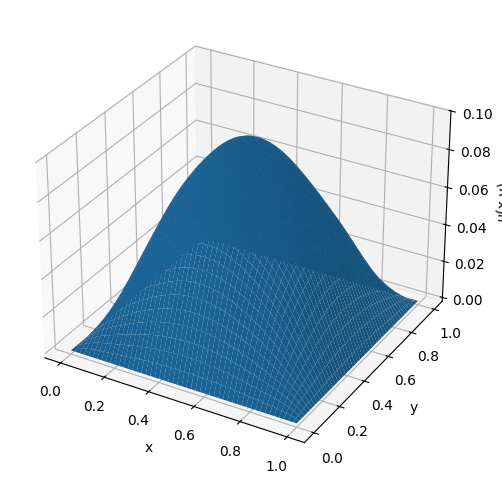

In [120]:
#Sanity test 
from src.solver_utils import solve_precond

elems=list(bh.basis[0].values())


def u_exact(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

def f_rhs(x, y, s=1):
    # f(x, y) = (2π²)^s * sin(πx) sin(πy)
    return (2 * np.pi**2)**s * np.sin(np.pi * x) * np.sin(np.pi * y)

b=bh.project_f_2d(f_rhs,level=0)

x=solve_precond(M,b)
u_num=reconstruct_solution(x,elems)


l2err=l2_error(u_num, u_exact)
print(f"L2 error: {l2err}")

n=200
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X, Y = np.meshgrid(x, y)
Z = u_num(X, Y)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, Z)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x,y)")

plt.show()

Stf matrix computation complete
L2 error: 743.0899305628548


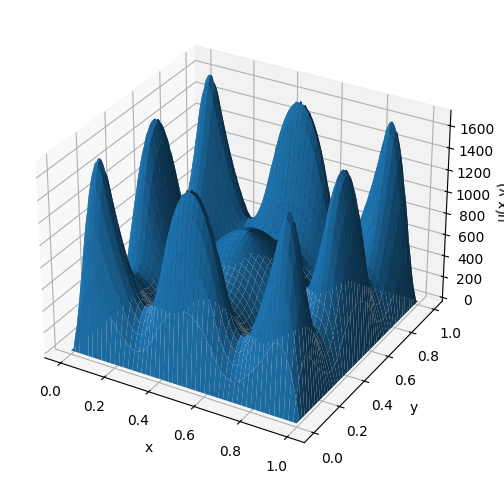

In [146]:
####Test run 
elems=list(bh.basis[0].values())
s=0.8

#Computing stiffnes 
def B_functional(elem_i,elem_j,s=s):
    return fractional_stiffness_entry(elem_i,elem_j,s)

S=big_chungus_I(elems,B_functional)
print("Stf matrix computation complete")

#Setting up test pair 
def u_exact_ext(x, y):
    inside = (0.0 <= x) & (x <= 1.0) & (0.0 <= y) & (y <= 1.0)
    val = np.sin(np.pi * x) * np.sin(np.pi * y)
    return np.where(inside, val, 0.0)

xs, ys, F = build_f_grid(s=s, q=32, Nx=80, Ny=80)
b = project_grid_onto_basis(xs, ys, F, elems)
# f_rhs = make_f_rhs(u_exact_ext, s, q=40)
# print("Rhs created")


# #Project soultion and solve preconditioned system.
# b=bh.project_f_2d(f_rhs,level=0)
# print("Rhs projected")


x=solve_precond(S,b)
u_num=reconstruct_solution(x,elems)


l2err=l2_error(u_num, u_exact)
print(f"L2 error: {l2err}")

#Plot the result
n=200
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X, Y = np.meshgrid(x, y)
Z = u_num(X, Y)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, Z)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x,y)")

plt.show()



In [135]:
#Debug
Nx, Ny = 200, 200
xs = np.linspace(0, 1, Nx)
ys = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(xs, ys, indexing="ij")
U = np.sin(np.pi*X) * np.sin(np.pi*Y) 

b_u = project_grid_onto_basis(xs, ys, U, elems)
u_proj = reconstruct_solution(b_u, elems)

err_proj = l2_error(u_proj, lambda x,y: np.sin(np.pi*x) * np.sin(np.pi*y))
print("L2 error of projection-only test:", err_proj)


L2 error of projection-only test: 0.06792324509094144


In [122]:
#Stash of unused shit
# def fractional_laplacian_fft(f_vals, s, L=1.0):
#     """
#     Approximate (-Δ)^s f on a square box of side length L using FFT.
#     f_vals: (N, N) values of f on a uniform grid.
#     s: order of the operator (i.e. we apply (-Δ)^s).
#     L: physical length of the box in each dimension.
#     """
#     N = f_vals.shape[0]
#     h = L / N  # grid spacing

#     F = np.fft.fftn(f_vals)

#     kx = 2.0 * np.pi * np.fft.fftfreq(N, d=h)
#     ky = 2.0 * np.pi * np.fft.fftfreq(N, d=h)
#     KX, KY = np.meshgrid(kx, ky, indexing='ij')

#     symbol = (KX*KX + KY*KY)**s
#     symbol[0, 0] = 0.0  # kill DC

#     return np.real(np.fft.ifftn(symbol * F))

# def stiffness_entry_fft(f_i, f_j, s=1.0, N=256, x_min=-4.0, x_max=4.0):
#     """
#     Approximate A_ij = ∫ ((-Δ)^{s/2} φ_i)((-Δ)^{s/2} φ_j) dx
#     using FFT on [x_min, x_max]^2.

#     f_i, f_j: callables φ_i(x, y), φ_j(x, y) defined on R^2
#     s: fractional order in the PDE
#     N: grid size per dimension
#     x_min, x_max: box for the FFT (same in x and y)
#     """
#     L = x_max - x_min
#     h = L / N

#     # uniform grid on the chosen box
#     x = np.linspace(x_min, x_max, N, endpoint=False)
#     X, Y = np.meshgrid(x, x)

#     # sample basis functions
#     phi_i_vals = f_i(X, Y)
#     phi_j_vals = f_j(X, Y)

#     # apply (-Δ)^{s/2} to both
#     Ls2_phi_i = fractional_laplacian_fft(phi_i_vals, s/2, L=L)
#     Ls2_phi_j = fractional_laplacian_fft(phi_j_vals, s/2, L=L)

#     # discrete approximation of ∫ g_i g_j
#     Aij = np.sum(Ls2_phi_i * Ls2_phi_j) * (h * h)
#     return Aij